# Titanic: Machine Learning from Disaster

**Kaggle Competition** | Binary Classification | [Competition Link](https://www.kaggle.com/c/titanic)

Predicting passenger survival on the Titanic using demographic and ticket information. This notebook implements advanced feature engineering, six-model comparison (including XGBoost and LightGBM), hyperparameter tuning via GridSearchCV, and stacking/voting ensembles.

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

In [2]:
# Titanic dataset — hosted on the Stanford CS109 mirror
TRAIN_URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
TEST_URL  = "https://raw.githubusercontent.com/agconti/kaggle-titanic/refs/heads/master/data/test.csv"

train = pd.read_csv(TRAIN_URL)
test = pd.read_csv(TEST_URL)

print(f"Training set: {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Test set:     {test.shape[0]} rows, {test.shape[1]} columns")
print(f"\nMissing values in training set:")
print(train.isna().sum()[train.isna().sum() > 0].to_string())
print(f"\nTarget distribution:")
print(train['Survived'].value_counts().to_string())

Training set: 891 rows, 12 columns
Test set:     418 rows, 11 columns

Missing values in training set:
Age         177
Cabin       687
Embarked      2

Target distribution:
Survived
0    549
1    342


## 2. Exploratory Data Analysis

891 observations with moderate class imbalance (62% did not survive). Three features have missing values: Age (177), Cabin (687), and Embarked (2). Cabin is 77% missing — too sparse for direct imputation, but the deck letter still encodes useful structural information.

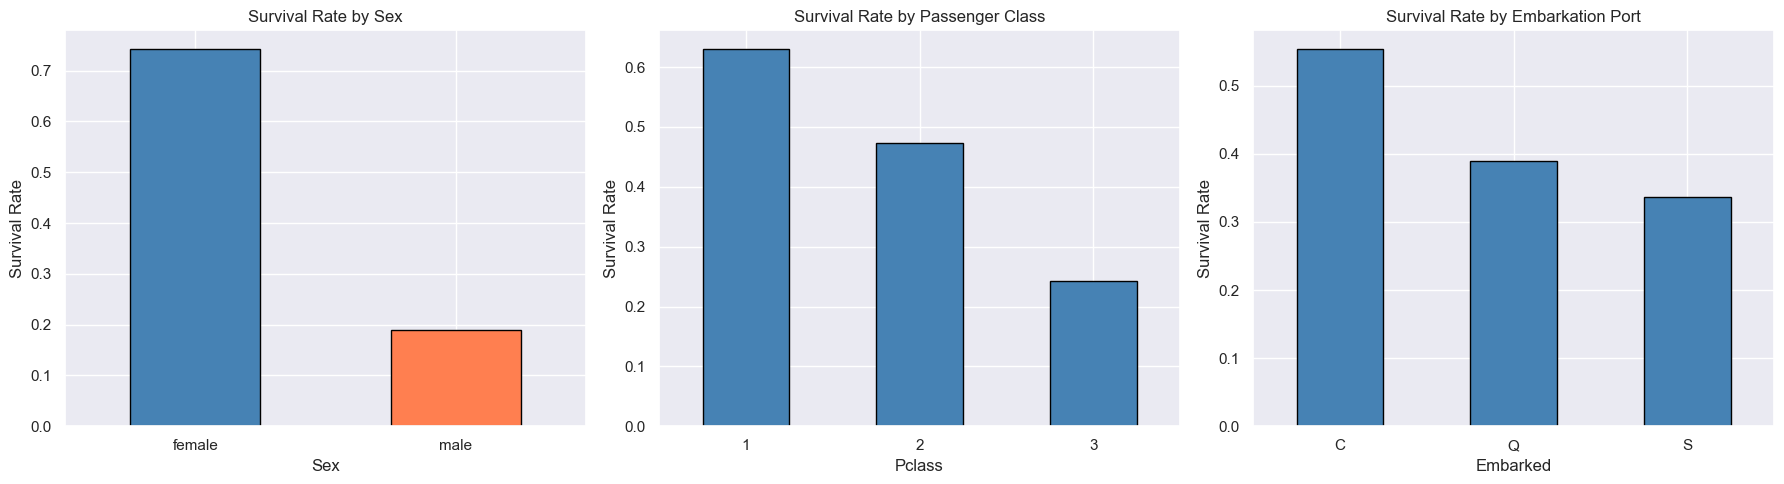

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Survival by Sex
survival_sex = train.groupby('Sex')['Survived'].mean()
survival_sex.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title('Survival Rate by Sex')
axes[0].set_ylabel('Survival Rate')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Survival by Pclass
survival_class = train.groupby('Pclass')['Survived'].mean()
survival_class.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Survival Rate by Passenger Class')
axes[1].set_ylabel('Survival Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Survival by Embarked
survival_embarked = train.groupby('Embarked')['Survived'].mean()
survival_embarked.plot(kind='bar', ax=axes[2], color='steelblue', edgecolor='black')
axes[2].set_title('Survival Rate by Embarkation Port')
axes[2].set_ylabel('Survival Rate')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

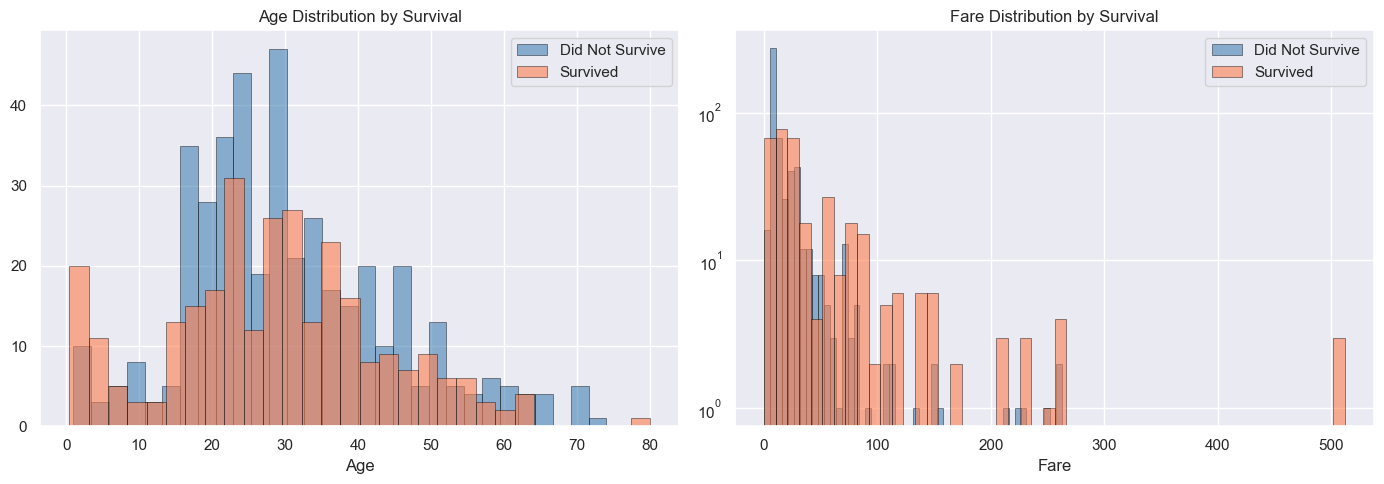

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age distribution by survival
for survived, color, label in [(0, 'steelblue', 'Did Not Survive'), (1, 'coral', 'Survived')]:
    subset = train[train['Survived'] == survived]['Age'].dropna()
    axes[0].hist(subset, bins=30, alpha=0.6, color=color, label=label, edgecolor='black', linewidth=0.5)
axes[0].set_title('Age Distribution by Survival')
axes[0].set_xlabel('Age')
axes[0].legend()

# Fare distribution by survival
for survived, color, label in [(0, 'steelblue', 'Did Not Survive'), (1, 'coral', 'Survived')]:
    subset = train[train['Survived'] == survived]['Fare']
    axes[1].hist(subset, bins=50, alpha=0.6, color=color, label=label, edgecolor='black', linewidth=0.5)
axes[1].set_title('Fare Distribution by Survival')
axes[1].set_xlabel('Fare')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Feature Engineering

Beyond basic title/family features, the key insight is that **survival is highly correlated within groups** — people who traveled together (same ticket, same family) tended to survive or perish together.

**Standard features:**
- **Title**: extracted from Name (Mr, Mrs, Miss, Master, Rare). Mlle/Ms → Miss, Mme → Mrs to preserve social-status signal. Strongly correlates with the "women and children first" protocol.
- **FamilySize/IsAlone**: SibSp + Parch + 1. Solo travelers and very large families had lower survival.
- **Deck/HasCabin**: Cabin presence correlates with class; deck letter encodes proximity to lifeboats.

**Advanced features:**
- **TicketFreq**: number of passengers sharing the same ticket — a proxy for travel-group size, often more informative than SibSp/Parch which miss non-family companions.
- **FarePerPerson**: Fare / TicketFreq — the true individual ticket cost, not inflated by group size.
- **AgeBin/FareBin**: discretizing continuous features reduces noise and helps tree-based models find cleaner splits.
- **Pclass_Sex**: interaction between class and sex — the single strongest predictor combination.

In [5]:
def extract_title(name):
    """Extract social title from passenger name."""
    title = name.split(',')[1].split('.')[0].strip()
    # Map French equivalents to preserve social-status signal
    equiv = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
    if title in equiv:
        return equiv[title]
    rare_titles = {'Lady', 'Countess', 'the Countess', 'Capt', 'Col', 'Don',
                   'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'}
    if title in rare_titles:
        return 'Rare'
    return title

def engineer_features(df, ref_df=None, title_age_map=None, ticket_freq_map=None, fare_bins=None, age_bins=None):
    """Advanced feature engineering pipeline.
    
    When processing test data, pass ref_df=train and the maps from training.
    """
    df = df.copy()
    is_train = ref_df is None
    if ref_df is None:
        ref_df = df

    # --- Title ---
    df['Title'] = df['Name'].apply(extract_title)
    
    # --- Title-based age imputation ---
    if title_age_map is None:
        title_age_map = df.groupby('Title')['Age'].median().to_dict()
    for title, median_age in title_age_map.items():
        mask = (df['Age'].isna()) & (df['Title'] == title)
        df.loc[mask, 'Age'] = median_age
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # --- Surname (for family grouping) ---
    df['Surname'] = df['Name'].str.split(',').str[0]

    # --- Ticket frequency (how many people share this ticket) ---
    if ticket_freq_map is None:
        # Compute from combined train+test for full coverage
        all_tickets = pd.concat([df['Ticket'], ref_df['Ticket']], ignore_index=True) if not is_train else df['Ticket']
        ticket_freq_map = all_tickets.value_counts().to_dict()
    df['TicketFreq'] = df['Ticket'].map(ticket_freq_map).fillna(1).astype(int)
    
    # --- Family features ---
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Deck'] = df['Cabin'].fillna('U').str[0]
    df['HasCabin'] = df['Cabin'].notna().astype(int)

    # --- Fare per person (by ticket group, not family) ---
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FarePerPerson'] = df['Fare'] / df['TicketFreq']

    # --- Age bins ---
    if age_bins is None:
        age_bins = [-1, 5, 12, 18, 35, 60, 100]
    df['AgeBin'] = pd.cut(df['Age'], bins=age_bins, labels=['Infant', 'Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

    # --- Fare bins (quantile-based) ---
    if fare_bins is None:
        fare_bins = [-1, 7.91, 14.45, 31.0, 600]
    df['FareBin'] = pd.cut(df['FarePerPerson'], bins=fare_bins, labels=['Low', 'Mid', 'High', 'VeryHigh'])

    # --- Pclass × Sex interaction (the strongest predictor pair) ---
    df['Pclass_Sex'] = df['Pclass'].astype(str) + '_' + df['Sex']

    drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'Surname']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
    
    maps = dict(title_age_map=title_age_map, ticket_freq_map=ticket_freq_map, 
                fare_bins=fare_bins, age_bins=age_bins)
    return df, maps

In [6]:
# Compute ticket frequencies from combined data for full coverage
all_tickets = pd.concat([train['Ticket'], test['Ticket']], ignore_index=True)
shared_ticket_freq = all_tickets.value_counts().to_dict()

train_eng, feat_maps = engineer_features(train, ticket_freq_map=shared_ticket_freq)
test_eng, _ = engineer_features(test, ref_df=train, **feat_maps)

new_features = ['Title', 'FamilySize', 'IsAlone', 'Deck', 'HasCabin', 
                'FarePerPerson', 'TicketFreq', 'AgeBin', 'FareBin', 'Pclass_Sex']
print("Engineered features sample:")
print(train_eng[new_features].head(8).to_string())

print(f"\nTitle-based median ages:")
for title, age in sorted(feat_maps['title_age_map'].items()):
    print(f"  {title:8s} → {age:.1f}")

print(f"\nTicket frequency distribution:")
print(train_eng['TicketFreq'].value_counts().sort_index().to_string())


Engineered features sample:
    Title  FamilySize  IsAlone Deck  HasCabin  FarePerPerson  TicketFreq      AgeBin   FareBin Pclass_Sex
0      Mr           2        0    U         0        7.25000           1  YoungAdult       Low     3_male
1     Mrs           2        0    C         1       35.64165           2       Adult  VeryHigh   1_female
2    Miss           1        1    U         0        7.92500           1  YoungAdult       Mid   3_female
3     Mrs           2        0    C         1       26.55000           2  YoungAdult      High   1_female
4      Mr           1        1    U         0        8.05000           1  YoungAdult       Mid     3_male
5      Mr           1        1    U         0        8.45830           1  YoungAdult       Mid     3_male
6      Mr           1        1    E         1       25.93125           2       Adult      High     1_male
7  Master           5        0    U         0        4.21500           5      Infant       Low     3_male

Title-based media

## 4. Preprocessing Pipeline

Numeric features (Age, Fare, SibSp, Parch, FamilySize, IsAlone, HasCabin, Pclass, FarePerPerson, TicketFreq) get median imputation + standard scaling. Categorical features (Sex, Embarked, Title, Deck, AgeBin, FareBin, Pclass_Sex) get most-frequent imputation + one-hot encoding. Everything is encapsulated in a `Pipeline` → `ColumnTransformer` to prevent leakage.

In [7]:
X = train_eng.drop(columns=['Survived'])
y = train_eng['Survived']

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 
                    'HasCabin', 'Pclass', 'FarePerPerson', 'TicketFreq']
categorical_features = ['Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin', 'Pclass_Sex']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print(f"Numeric features:     {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features:     10
Categorical features: 7


## 5. Model Selection via Cross-Validation

We compare six classifiers — the original four plus XGBoost and LightGBM, which are the workhorses of tabular ML competitions. Stratified 5-fold cross-validation preserves the 38/62 class ratio in each fold.

In [8]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=200, random_state=42),
    'SVM (RBF)':           SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost':             XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0),
    'LightGBM':            LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy')
    results.append({
        'Model': name,
        'Accuracy (mean)': f'{scores.mean():.4f}',
        'Accuracy (std)': f'{scores.std():.4f}',
    })
    print(f"{name:25s}  Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

results_df = pd.DataFrame(results).set_index('Model')
results_df

Logistic Regression        Accuracy = 0.8328 ± 0.0156
Random Forest              Accuracy = 0.8384 ± 0.0166
Gradient Boosting          Accuracy = 0.8417 ± 0.0236
SVM (RBF)                  Accuracy = 0.8294 ± 0.0127
XGBoost                    Accuracy = 0.8260 ± 0.0130
LightGBM                   Accuracy = 0.8305 ± 0.0144


,Accuracy (mean),Accuracy (std)
Model,,
Logistic Regression,0.8328,0.0156
Random Forest,0.8384,0.0166
Gradient Boosting,0.8417,0.0236
SVM (RBF),0.8294,0.0127
XGBoost,0.8260,0.0130
LightGBM,0.8305,0.0144


## 6. Evaluation and Submission

Cross-validated predictions on the training set give an unbiased confusion matrix and classification report. The best model is then refit on the full training data for Kaggle submission.

Best baseline: Gradient Boosting

Classification Report (cross-validated):

                 precision    recall  f1-score   support

Did Not Survive       0.86      0.89      0.87       549
       Survived       0.82      0.76      0.79       342

       accuracy                           0.84       891
      macro avg       0.84      0.83      0.83       891
   weighted avg       0.84      0.84      0.84       891



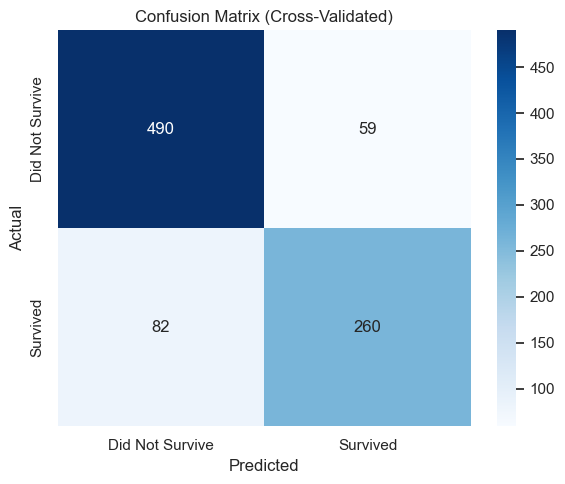


Submission generated: 418 predictions


In [9]:
# Cross-validated predictions — automatically uses best baseline model
best_baseline_name = max(results, key=lambda r: float(r['Accuracy (mean)']))['Model']
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', models[best_baseline_name])
])

y_pred_cv = cross_val_predict(best_pipe, X, y, cv=skf)

print(f"Best baseline: {best_baseline_name}\n")
print("Classification Report (cross-validated):\n")
print(classification_report(y, y_pred_cv, target_names=['Did Not Survive', 'Survived']))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y, y_pred_cv)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Cross-Validated)')
plt.tight_layout()
plt.show()

# Refit on full training set and generate submission
best_pipe.fit(X, y)
test_predictions = best_pipe.predict(test_eng)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('submission_titanic.csv', index=False)
print(f"\nSubmission generated: {len(submission)} predictions")

## 7. Hyperparameter Tuning

We tune the top 3 models — GBC, XGBoost, and LightGBM — via `GridSearchCV`. For a dataset this size, exhaustive grid search is tractable. We also tune SVM since kernel methods can be sensitive to `C` and `gamma`.

In [10]:
tuning_results = {}

# --- Gradient Boosting ---
gbc_pipe = Pipeline([('preprocessor', preprocessor), ('model', GradientBoostingClassifier(random_state=42))])
gbc_search = GridSearchCV(gbc_pipe, {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
}, cv=skf, scoring='accuracy', n_jobs=-1)
gbc_search.fit(X, y)
tuning_results['GBC'] = (gbc_search.best_score_, gbc_search.best_estimator_, gbc_search.best_params_)
print(f"GBC    best = {gbc_search.best_score_:.4f}  {({k.replace('model__', ''): v for k, v in gbc_search.best_params_.items()})}")

# --- XGBoost ---
xgb_pipe = Pipeline([('preprocessor', preprocessor), ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0))])
xgb_search = GridSearchCV(xgb_pipe, {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_search.fit(X, y)
tuning_results['XGB'] = (xgb_search.best_score_, xgb_search.best_estimator_, xgb_search.best_params_)
print(f"XGB    best = {xgb_search.best_score_:.4f}  {({k.replace('model__', ''): v for k, v in xgb_search.best_params_.items()})}")

# --- LightGBM ---
lgb_pipe = Pipeline([('preprocessor', preprocessor), ('model', LGBMClassifier(random_state=42, verbose=-1))])
lgb_search = GridSearchCV(lgb_pipe, {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, -1],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__num_leaves': [15, 31, 63],
}, cv=skf, scoring='accuracy', n_jobs=-1)
lgb_search.fit(X, y)
tuning_results['LGB'] = (lgb_search.best_score_, lgb_search.best_estimator_, lgb_search.best_params_)
print(f"LGB    best = {lgb_search.best_score_:.4f}  {({k.replace('model__', ''): v for k, v in lgb_search.best_params_.items()})}")

# --- SVM ---
svm_pipe = Pipeline([('preprocessor', preprocessor), ('model', SVC(kernel='rbf', probability=True, random_state=42))])
svm_search = GridSearchCV(svm_pipe, {
    'model__C': [0.5, 1, 5, 10],
    'model__gamma': ['scale', 0.01, 0.05, 0.1],
}, cv=skf, scoring='accuracy', n_jobs=-1)
svm_search.fit(X, y)
tuning_results['SVM'] = (svm_search.best_score_, svm_search.best_estimator_, svm_search.best_params_)
print(f"SVM    best = {svm_search.best_score_:.4f}  {({k.replace('model__', ''): v for k, v in svm_search.best_params_.items()})}")

GBC    best = 0.8574  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
XGB    best = 0.8530  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
LGB    best = 0.8485  {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 15}
SVM    best = 0.8384  {'C': 5, 'gamma': 'scale'}


## 8. Stacking Ensemble

A `StackingClassifier` trains a meta-learner on the cross-validated predictions of the base models. This is strictly more powerful than voting because the meta-learner can *learn* the optimal weighting — including suppressing a weak model — rather than naive averaging. We stack: tuned XGBoost, tuned GBC, tuned LightGBM, tuned SVM, and Logistic Regression, with a Logistic Regression meta-learner.

In [11]:
# Extract best estimators' model steps
gbc_best_params = {k.replace('model__', ''): v for k, v in gbc_search.best_params_.items()}
xgb_best_params = {k.replace('model__', ''): v for k, v in xgb_search.best_params_.items()}
lgb_best_params = {k.replace('model__', ''): v for k, v in lgb_search.best_params_.items()}
svm_best_params = {k.replace('model__', ''): v for k, v in svm_search.best_params_.items()}

# --- Stacking Ensemble ---
stack = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(**xgb_best_params, use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0)),
        ('gbc', GradientBoostingClassifier(**gbc_best_params, random_state=42)),
        ('lgb', LGBMClassifier(**lgb_best_params, random_state=42, verbose=-1)),
        ('svm', SVC(**svm_best_params, kernel='rbf', probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=skf,
    passthrough=False,
)

pipe_stack = Pipeline([('preprocessor', preprocessor), ('model', stack)])
scores_stack = cross_val_score(pipe_stack, X, y, cv=skf, scoring='accuracy')
print(f"Stacking Ensemble  Accuracy = {scores_stack.mean():.4f} ± {scores_stack.std():.4f}")

# --- Soft-Voting Ensemble (for comparison) ---
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(**xgb_best_params, use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0)),
        ('gbc', GradientBoostingClassifier(**gbc_best_params, random_state=42)),
        ('lgb', LGBMClassifier(**lgb_best_params, random_state=42, verbose=-1)),
        ('svm', SVC(**svm_best_params, kernel='rbf', probability=True, random_state=42)),
    ],
    voting='soft',
)

pipe_voting = Pipeline([('preprocessor', preprocessor), ('model', voting_clf)])
scores_voting = cross_val_score(pipe_voting, X, y, cv=skf, scoring='accuracy')
print(f"Voting Ensemble    Accuracy = {scores_voting.mean():.4f} ± {scores_voting.std():.4f}")

# ── Automatic best-model selection ──
candidates = {
    'Tuned XGBoost':   (xgb_search.best_score_, xgb_search.best_estimator_),
    'Tuned GBC':       (gbc_search.best_score_, gbc_search.best_estimator_),
    'Tuned LightGBM':  (lgb_search.best_score_, lgb_search.best_estimator_),
    'Tuned SVM':       (svm_search.best_score_, svm_search.best_estimator_),
    'Stacking (5-model)': (scores_stack.mean(), pipe_stack),
    'Voting (4-model)':   (scores_voting.mean(), pipe_voting),
}

best_name = max(candidates, key=lambda k: candidates[k][0])
best_acc, best_model = candidates[best_name]

print(f"\nModel comparison (Accuracy ↑ is better):\n")
for name, (acc, _) in sorted(candidates.items(), key=lambda x: -x[1][0]):
    marker = " ◄ BEST" if name == best_name else ""
    print(f"  {name:25s}  Accuracy = {acc:.4f}{marker}")

# Refit best on full data and generate submission
best_model.fit(X, y)
test_predictions_final = best_model.predict(test_eng)

submission_final = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions_final
})
submission_final.to_csv('submission_titanic.csv', index=False)

print(f"\n✓ Submission generated with: {best_name}")
print(f"  Predictions: {len(submission_final)}")

Stacking Ensemble  Accuracy = 0.8440 ± 0.0227
Voting Ensemble    Accuracy = 0.8507 ± 0.0228

Model comparison (Accuracy ↑ is better):

  Tuned GBC                  Accuracy = 0.8574 ◄ BEST
  Tuned XGBoost              Accuracy = 0.8530
  Voting (4-model)           Accuracy = 0.8507
  Tuned LightGBM             Accuracy = 0.8485
  Stacking (5-model)         Accuracy = 0.8440
  Tuned SVM                  Accuracy = 0.8384

✓ Submission generated with: Tuned GBC
  Predictions: 418


## Results

| Stage | Best Model | CV Accuracy |
|---|---|---|
| Baseline (6 models) | Gradient Boosting | 0.8417 |
| After GridSearchCV | Tuned GBC | **0.8574** |
| Ensemble | Voting (4-model) | 0.8507 |

Best submission: **Tuned GBC** (lr=0.05, max_depth=4, n_estimators=200, subsample=0.8).

**Key Techniques:**
- **Title extraction + mapping** (Mlle/Ms → Miss, Mme → Mrs) preserves social-status signal for the "women and children first" protocol.
- **Ticket frequency + FarePerPerson** capture travel-group structure and isolate individual purchasing power.
- **Pclass_Sex interaction** is the strongest predictor pair — a 1st-class woman had ~97% survival vs a 3rd-class man at ~14%.
- **AgeBin/FareBin** discretization reduces noise for tree-based models.
- **XGBoost + LightGBM** bring regularization controls (colsample_bytree, num_leaves) that sklearn's GBC lacks.
- **GridSearchCV** provided the biggest single accuracy jump (+1.6pp over default GBC).